# Car Recognition with Deep Learning

This tutorial shows how Deep Neural Networks are used to recognize cars on images versus images with no cars on them (binary classification).

In [9]:
import os
#os.environ['THEANO_FLAGS']='mode=FAST_RUN,device=' + device + ',floatX=float32,nvcc.flags=-D_FORCE_INLINES'

import argparse
import csv
import datetime
import glob
import math
import sys
import time

import numpy as np

import pandas as pd # Pandas for easier Data handling in preparation

from sklearn import preprocessing
from sklearn.cross_validation import ShuffleSplit, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix

from theano import config
from theano import function as tfunction

import keras
from keras.optimizers import SGD, RMSprop, Adagrad

from PIL import Image

In [67]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD

In [5]:
from progressbar import ProgressBar
# needed?
from keras.preprocessing import image
from keras.callbacks import Callback, History, EarlyStopping, ModelCheckpoint # BaseLogger,

import json
#import cPickle # for saving scaler and labelencoder

In [3]:

RANDOM_SEED = 2107


## Load the Images from Training Set

In [3]:
path = 'data/CarData/TrainImages'
files = glob.glob(os.path.join(path, '*.pgm'))
print "Found", len(files), "files"

Found 1050 files


In [33]:
images = []
image_names = []

for filename in files:
    image_names.append(os.path.basename(filename))
    #img = Image.open(filename)
    with Image.open(filename) as img:
        images.append(np.array(img))

neg-85.pgm


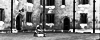

In [36]:
i=0
print image_names[i]
Image.fromarray(images[i])

In [45]:
type(images[i])

numpy.ndarray

In [46]:
images[i].shape   # height x width

(40, 100)

Note: Color RGB images have an additional dimension of depth 3, e.g. (40, 100, 3)

## Make 1 big array of list of images

In [48]:
# a list of 40x100 images is made into 1 big array
# config.floatX is from Theano configration to enforce float32 precision (needed for GPU computation)
img_array = np.array(images, dtype=config.floatX)
img_array.shape

(1050, 40, 100)

## Create the Groundtruth based on filenames:

In [37]:
classes = []
for name in image_names:
    if name.startswith('neg'):
        classes.append(0)
    else:
        classes.append(1)

In [47]:
classes

[0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,


In [40]:
print "Groundtruth Statistics:"

for v in set(classes):
    print "Class", v, ":", classes.count(v)

Groundtruth Statistics:
Class 0 : 500
Class 1 : 550


In [43]:
baseline = 550 * 1.0 / len(classes)
baseline

0.5238095238095238

## Standardization

Always standardize the data before feeding it into the Neural Network!

Here we use <b>Zero-mean Unit-variance standardization</b> (flat, i.e. one mean and std.dev. for the whole image is computed over all pixels; in RGB images, standardization can be done e.g. for each colour channel individually; in other/non-image data sets, attribute-wise standardization should be applied).

In [52]:
mean = img_array.mean()
stddev = img_array.std()
print mean, stddev

129.582 74.2767


In [53]:
img_array = (img_array - mean) / stddev
print img_array.mean(), img_array.std()

1.27098e-07 1.0


In [55]:
img_array.min(), img_array.max()

(-1.7445904, 1.6885173)

# TODO

In [65]:

# create folds
folds = 3
splits = StratifiedKFold(classes, n_folds=folds, shuffle=True, random_state=RANDOM_SEED)

    for train_ind, test_ind in splits:
        print "Train:", len(train_ind), "Test:", len(test_ind)


In [113]:
train_img = images[train_ind]
test_img = images[test_ind]

In [68]:
train_gt = groundtruth[train_ind]
test_gt = groundtruth[test_ind]

In [115]:
input_shape = images.shape[1:]
output_units = 1

multi_class = output_units > 1
multi_class

False

# Creating NN Models in Keras

## 1) Fully Connected NN

For a fully connected neural network, the images have to be flattened, as the x and y axis do not play a role. All pixels are considered as a completely individual input to the neural network.

In [87]:
#  flatten images to vectors
images_flat = img_array.reshape(img_array.shape[0],-1)

# find out new shape, which is just a long vector (40x100 = 4000)
input_shape = images_flat.shape[1]

print images_flat.shape
print input_shape

(1050, 4000)
4000


### Create a model of 2 fully connected (a.k.a. 'dense') layers of 256 units each:

In [84]:
# simple Fully-connected network

model = Sequential()

model.add(Dense(256, input_dim=input_shape))

model.add(Dense(256))

model.add(Dense(1,activation='sigmoid'))



In [71]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 256)           1024256     dense_input_1[0][0]              
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 256)           65792       dense_1[0][0]                    
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 1)             257         dense_2[0][0]                    
Total params: 1090305
____________________________________________________________________________________________________


In [85]:
# Preparing / compiling the model
loss = 'binary_crossentropy' 
optimizer = 'sgd' #rmsprop'

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    

In [86]:
epochs = 15
model.fit(images_flat, classes, batch_size=32, nb_epoch=epochs) # validation_data=validation_data, 

Epoch 1/15
1050/1050 [==============================] - 0s - loss: 0.5353 - acc: 0.7743     
Epoch 2/15
1050/1050 [==============================] - 0s - loss: 0.2999 - acc: 0.8619     
Epoch 3/15
1050/1050 [==============================] - 0s - loss: 0.2281 - acc: 0.9010     
Epoch 4/15
1050/1050 [==============================] - 0s - loss: 0.1737 - acc: 0.9314     
Epoch 5/15
1050/1050 [==============================] - 0s - loss: 0.1496 - acc: 0.9448     
Epoch 6/15
1050/1050 [==============================] - 0s - loss: 0.1171 - acc: 0.9657     
Epoch 7/15
1050/1050 [==============================] - 0s - loss: 0.0987 - acc: 0.9752     
Epoch 8/15
1050/1050 [==============================] - 0s - loss: 0.0829 - acc: 0.9848     
Epoch 9/15
1050/1050 [==============================] - 0s - loss: 0.0700 - acc: 0.9848     
Epoch 10/15
1050/1050 [==============================] - 0s - loss: 0.0529 - acc: 0.9914     
Epoch 11/15
1050/1050 [==============================] - 0s - loss: 0

In [91]:
# verify Accuracy on Train set
pred = model.predict_classes(images_flat)
accuracy_score(pred, classes)

 928/1050 [=========================>....] - ETA: 0s

1.0

# Testing with Test Data Set

In [92]:
path = 'data/CarData/TestImages'
files = glob.glob(os.path.join(path, '*.pgm'))
print "Found", len(files), "files"

Found 170 files


In [93]:
test_images = []
test_image_names = []

for filename in files:
    test_image_names.append(os.path.basename(filename))
    #img = Image.open(filename)
    with Image.open(filename) as img:
        test_images.append(np.array(img))
        print img.size

(225, 127)
(184, 124)
(186, 121)
(160, 83)
(176, 120)
(185, 126)
(200, 150)
(225, 143)
(204, 127)
(179, 100)
(163, 111)
(190, 123)
(200, 150)
(172, 117)
(264, 145)
(261, 156)
(174, 96)
(167, 110)
(170, 98)
(138, 87)
(240, 145)
(325, 147)
(120, 82)
(146, 94)
(301, 179)
(186, 116)
(119, 90)
(235, 143)
(153, 115)
(229, 146)
(209, 143)
(190, 130)
(180, 126)
(206, 137)
(266, 147)
(265, 199)
(235, 117)
(155, 106)
(235, 134)
(194, 125)
(150, 88)
(159, 111)
(138, 73)
(234, 126)
(168, 106)
(219, 132)
(205, 134)
(144, 98)
(175, 119)
(147, 100)
(200, 119)
(302, 146)
(160, 104)
(183, 123)
(189, 110)
(280, 138)
(200, 139)
(135, 93)
(140, 88)
(206, 136)
(175, 119)
(157, 107)
(160, 109)
(266, 158)
(150, 90)
(132, 106)
(230, 157)
(207, 116)
(245, 157)
(270, 162)
(266, 140)
(181, 98)
(146, 110)
(145, 99)
(160, 97)
(149, 112)
(252, 155)
(212, 128)
(142, 83)
(125, 85)
(175, 119)
(217, 141)
(200, 113)
(228, 128)
(178, 109)
(159, 119)
(165, 102)
(360, 176)
(167, 99)
(220, 124)
(160, 109)
(225, 140)
(250, 1

In [77]:
# TESTING
test_pred = model.predict_classes(test_img)
acc = accuracy_score(test_gt, test_pred)
acc

5223/5223 [==============================] - 8s     


0.72372199885123489

In [117]:
# simple CNN to test

model = Sequential()
# input: 100x100 images with 3 channels -> input_shape should be (3, 100, 100) 
# this applies 32 convolution filters of size 3x3 each.
model.add(Convolution2D(32, 3, 3, border_mode='valid', input_shape=input_shape))
#model.add(Activation('relu')) # WAS COMMENTED OUT WHEN WORKED
#model.add(MaxPooling2D(pool_size=(2, 2))) # NEW
#model.add(Dropout(0.1)) # NEW

model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Flatten())
# Note: Keras does automatic shape inference.
model.add(Dense(256))
#model.add(Activation('relu'))
model.add(Dropout(0.1))

if output_units > 1:
    model.add(Dense(output_units))
    model.add(Activation('softmax'))
else:
    model.add(Dense(1,activation='sigmoid'))


In [124]:
# VGG-like convnet:
# (from https://keras.io/getting-started/sequential-model-guide/)

model = Sequential()
# input: 100x100 images with 3 channels -> input_shape should be (3, 100, 100) 
# this applies 32 convolution filters of size 3x3 each.
model.add(Convolution2D(32, 3, 3, border_mode='valid', input_shape=input_shape))
model.add(Activation('relu'))
model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(64, 3, 3, border_mode='valid'))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
# Note: Keras does automatic shape inference.
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

if output_units > 1:
    model.add(Dense(output_units))
    model.add(Activation('softmax'))
else:
    model.add(Dense(1,activation='sigmoid'))


In [119]:
# we use test data as validation data to see direct results (usually not recommended)
validation_data = (test_img, test_gt)

In [72]:
if multi_class:
    loss = 'categorical_crossentropy' # multi class
    class_mode='categorical'
    #optimizer = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    # try simpler first
    optimizer = SGD(lr=0.001)
else: # binary 0/1
    loss = 'binary_crossentropy' 
    class_mode='binary'
    optimizer = 'rmsprop'
    #optimizer = RMSprop(lr=0.0001)
    #optimizer = 'adam'
    #optimizer = SGD(lr=0.001)

print "Class mode:", class_mode, ", multi_class:", multi_class
    

NameError: name 'multi_class' is not defined